This notebook contains different utilities: 
* transformation of graph data file formats
* automatic construction of RBNs from ACR-GNN specifications (and parameters)
* visualization of learning progress based on Primula log files



In [8]:
import numpy as np

import torch
from torch_geometric.data import Data

import sys
sys.path.append("GNN-logic/src")
import utils
from utils import util

import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from scipy.special import binom
from torch_geometric.utils import to_networkx

import pickle

The following code is needed to transform graph data files in the format used by the ACR-GNN implementation into the .rdef format used by Primula

In [1]:
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

def filetordef(dirpath,infile,outfile,includeprob,classlabel,generative):
    # generative: Boolean specifying whether in the rdef the color attributes
    # should be predefined or probabilistic
    rdeffile=open(dirpath+outfile,'w')
    rdeffile.write("<root> \n")
    print("Ensure that {} is the class specified in preamble.txt!".format(classlabel))
    if generative:
        pream = open(dirpath+"preamble-generative.txt",'r').read()
    else:
        pream = open(dirpath+"preamble.txt",'r').read()
    rdeffile.write(pream)
    
    rdeffile.write("<Data> \n")
    
    data,_ = util.load_data(
                    dataset=dirpath+infile,
                    degree_as_node_label=False)
    
    for i,G in enumerate(data):
        if np.random.random()<=includeprob:
            Gtordef(G,i,rdeffile,classlabel,generative)
        
#     Gtordef(data[0],rdeffile)
#     Gtordef(data[1],rdeffile)
    rdeffile.write("</Data> \n")
    rdeffile.write("</root> \n")
    
    rdeffile.close()
    return data


def Gtordef(G,i,rdeffile,classlabel,generative):
    rdeffile.write("<DataForInputDomain> \n")
    rdeffile.write("<!--" + str(i) +"--> \n")
    
    Domaintordef(G,rdeffile)
    Predeftordef(G,rdeffile,generative)
    Probtordef(G,rdeffile,classlabel,generative)
    
    rdeffile.write("</DataForInputDomain> \n")
    
def Domaintordef(G,rdeffile):    
    rdeffile.write("<Domain> \n")
    
    for i in range(G.x.shape[0]):
        rdeffile.write("<obj ind='" +str(i) + "' name='n" + str(i) +\
                       "' coords='"  + str(np.random.randint(1000)) +"," + str(np.random.randint(1000))  + "' /> \n")
    rdeffile.write("</Domain> \n")
    
def Predeftordef(G,rdeffile,generative):
    rdeffile.write("<PredefinedRels> \n")
    
    OneUnaryReltordef("node",range(G.x.shape[0]),rdeffile,True)
    
    if not generative:
        names=("blue","green","red","yellow","purple")
        for i in range(len(names)):
            OneUnaryReltordef(names[i],np.where(np.array(G.x)[:,i]==1)[0],rdeffile,True)
    
    OneBinaryReltordef("edge",np.array(G.edge_index),rdeffile)
    rdeffile.write("</PredefinedRels> \n")
    
def OneUnaryReltordef(name,objects,rdeffile,truefalse): #objects a list, array of integers
    rdeffile.write("<d rel='" + name + "' args='" )
    for o in objects:
        rdeffile.write("(n" + str(o) + ")")
    if truefalse:    
        rdeffile.write("' val='true'/> \n")
    else:
        rdeffile.write("' val='false'/> \n")
    
def OneBinaryReltordef(name,objects,rdeffile): #objects a 2xM matrix
    rdeffile.write("<d rel='" + name + "' args='" )
    for i in range(objects.shape[1]):
        if objects[0,i]<objects[1,i]: # add only one of the two symmetric edges
            rdeffile.write("(n" + str(objects[0,i]) + ",n" +  str(objects[1,i]) +")")
    rdeffile.write("' val='true'/> \n")
    
# def Probtordef(G,rdeffile):
#     rdeffile.write("<ProbabilisticRelsCase> \n")
#     OneUnaryReltordef("alpha1",np.where(np.array(G.node_labels)==1)[0],rdeffile,True)
#     OneUnaryReltordef("alpha1",np.where(np.array(G.node_labels)==0)[0],rdeffile,False)
#     rdeffile.write("</ProbabilisticRelsCase> \n")

def Probtordef(G,rdeffile,classlabel,generative):
    rdeffile.write("<ProbabilisticRelsCase> \n")
    if generative:
        names=("blue","green","red","yellow","purple")
        for i in range(len(names)):
            OneUnaryReltordef(names[i],np.where(np.array(G.x)[:,i]==1)[0],rdeffile,True)
    OneUnaryReltordef(classlabel,np.where(np.array(G.node_labels)==1)[0],rdeffile,True)
    OneUnaryReltordef(classlabel,np.where(np.array(G.node_labels)==0)[0],rdeffile,False)
    rdeffile.write("</ProbabilisticRelsCase> \n")

In [3]:
dirpath="GraphNN-develop/GNNdata/p1/"
infile="test-random-erdos-500-40-50.txt"
outfile="train-random-erdos-5000-40-50-generative.rdef"
sampleperc=100
# infile="train-random-erdos-5000-40-50.txt"
# outfile="train-random-erdos-5000-40-50-"+str(sampleperc) + ".rdef"
#data=filetordef(dirpath,infile,outfile,sampleperc,"alpha1",True)
data,_=util.load_data(
                     dataset=dirpath+infile,
                     degree_as_node_label=False)

Loading data...
#Graphs: 500
#Graphs Labels: 1
#Node Features: 5
#Node Labels: 2


In [ ]:
numedges = 0
numnodes =0
for G in data:
    numedges += G.edge_index.shape[1]/2
    numnodes += G.node_labels.shape[0]
    

print("Total number of edges: {}".format(numedges)) 
print("Total number of nodes: {}".format(numnodes))
print("Avg. number of nodes: {}".format(numnodes/len(data)))
print("Avg. degree: {}".format(2*numedges/numnodes))

In [ ]:
blueidx=0
allblue=np.where(G.x[:,blueidx]==1.0)
totalblue=len(allblue[0])
print("all blue: {}".format(allblue))
print("total blue: {}".format(totalblue))

def blueneighbors(v):
    neighbors= G.edge_index[1,np.where(G.edge_index[0,:]==v)] 
    return np.intersect1d(neighbors,allblue)

for v in range(50):
    print("{} \t {} \t {} ".format(v,totalblue-len(blueneighbors(v)),G.node_labels[v]))

In [ ]:
blueidx = 2
totalpos=0
total=0
nedges=0
for G in data:
    nnodes=G.x.shape[0]
    total+=nnodes
    nedges+=G.edge_index.shape[1]/2
    npos=np.sum(np.array(G.node_labels))
    totalpos+=npos
#     print("nodes: {}  edges: {}  blue: {}  positive: {} negative: {}".format(nnodes,\
#                                                   G.edge_index.shape[1]/2,\
#                                                   np.sum(np.array(G.x[:,blueidx])),\
#                                                   npos,\
#                                                   nnodes-npos))
    
    
print("base: {}".format(totalpos/total))
print("densitiy: {}".format(nedges/total))

In [ ]:
coloridx = 0
totalcol=0
total=0

for G in data:
    nnodes=G.x.shape[0]
    total+=nnodes
    totalcol+=np.sum(np.array(G.x[:,coloridx]))
                                              
    
    
print("colfrac: {}".format(totalcol/total))

In [20]:
blueidx=0

def blueneighbors(G,i):
    x=np.array(G.x)
    totalblue=np.sum(x[:,blueidx])
    #print("total blue: {}".format(totalblue))
    
    edge_index=np.array(G.edge_index)
    
    xneigh=x[edge_index[1,np.where(edge_index[0,:]==i)],:]
    bn=np.sum(xneigh[0][:,blueidx])
    pred=sigmoid(16*(totalblue-bn)-16)
    print("i: {} blue non neighbs: {}   non-blue neighbors: {} label: {}  pred: {}".format(i,totalblue-bn,\
                                                                           xneigh[0].shape[0]-bn,\
                                                                           G.node_labels[i],\
                                                                            pred))
    return totalblue-bn
    

In [21]:
G=data[2]
nnodes=len(G.node_labels)
print("num nodes: {}".format(nnodes))
print("total blue: {}".format(np.sum(np.array(G.x)[:,blueidx])))
for i in range(nnodes):
    blueneighbors(G,i)

num nodes: 49
total blue: 14.0
i: 0 blue non neighbs: 8.0   non-blue neighbors: 10.0 label: 1  pred: 1.0
i: 1 blue non neighbs: 9.0   non-blue neighbors: 8.0 label: 1  pred: 1.0
i: 2 blue non neighbs: 10.0   non-blue neighbors: 12.0 label: 1  pred: 1.0
i: 3 blue non neighbs: 9.0   non-blue neighbors: 10.0 label: 1  pred: 1.0
i: 4 blue non neighbs: 7.0   non-blue neighbors: 10.0 label: 0  pred: 1.0
i: 5 blue non neighbs: 11.0   non-blue neighbors: 9.0 label: 0  pred: 1.0
i: 6 blue non neighbs: 8.0   non-blue neighbors: 10.0 label: 1  pred: 1.0
i: 7 blue non neighbs: 11.0   non-blue neighbors: 10.0 label: 0  pred: 1.0
i: 8 blue non neighbs: 7.0   non-blue neighbors: 9.0 label: 0  pred: 1.0
i: 9 blue non neighbs: 11.0   non-blue neighbors: 8.0 label: 0  pred: 1.0
i: 10 blue non neighbs: 13.0   non-blue neighbors: 10.0 label: 0  pred: 1.0
i: 11 blue non neighbs: 12.0   non-blue neighbors: 5.0 label: 0  pred: 1.0
i: 12 blue non neighbs: 10.0   non-blue neighbors: 13.0 label: 1  pred: 1.0
i:

In [ ]:
total =0
for G in data:
    for i in range(len(G.node_labels)):
        if blueneighbors(G,i)>=11:
            total+=1
print(total)
print(total*np.log(0.5))

In [ ]:
x=np.array(G.x)
edge_index=np.array(G.edge_index)

for i in (1,29):
    print("i: {} label: {}".format(i,G.node_labels[i]))
    xneigh=x[edge_index[1,np.where(edge_index[0,:]==i)],:]
    print(xneigh)
    
    
    print(np.sum(xneigh[0][:,:],axis=0))
    print(np.sum(xneigh[0][:,:]))
    print()      

## Generate RBNs

Code for generating RBNs from a ACR-GNN specification given by a vector of layer dimensions. Can also take weights and biases learned by the Pytorch ACR-GNN implementation

In [10]:
def raformul(ra,layer,idx): #layer: layer being aggregated; idx: component of that layer
    result=""
    if ra=="r":
        result+="@read_" + str(layer) + "_" + str(idx) +"() = "
    elif ra=="a":
        result+="@agg_" + str(layer) + "_" + str(idx) +"([node]v) = "
    else:
        print("illegal first argument {} for raformul".format(ra))
    result+="COMBINE "  
    result+= "@layer_" + str(layer) + "_" + str(idx) +"(w) \n"
    result+="\t WITH sum \n\t FORALL w \n\t WHERE "
    if ra=="r":
        result+="node(w); \n"
    else: 
        result+="(edge(v,w)|edge(w,v)); \n"
    return(result)

def layerformul(layer,idx,dim,weights=None,biases=None): # layer (other than 0th layer), idx: component in this layer, dim: dimension
                                             # of preceding layer
    result="@layer_" + str(layer) + "_" + str(idx) +"([node]v)= COMBINE \n"
    if weights==None:
        for i in range(dim):
            result+= "\t ($c_" + str(layer) + "_"+ str(idx) +"_" + str(i) \
            +"*@layer_" + str(layer-1) + "_" + str(i) +"(v)), \n"
        for i in range(dim):    
            result+="\t ($A_"+ str(layer) + "_" + str(idx) + "_" + str(i) \
            +"*@agg_" + str(layer-1)+ "_" + str(i) +"(v)), \n"
        for i in range(dim):      
            result+="\t ($R_"+ str(layer) + "_" + str(idx) + "_" + str(i) \
            +"*@read_" + str(layer-1)+ "_" + str(i) +"()), \n"
    else:
        for i in range(dim):
            result+= "\t (" + str(weights[layer-1]['C'][idx,i].item()) \
            +"*@layer_" + str(layer-1) + "_" + str(i) +"(v)), \n"
        for i in range(dim):    
            result+="\t (" + str(weights[layer-1]['A'][idx,i].item()) \
            +"*@agg_" + str(layer-1)+ "_" + str(i) +"(v)), \n"
        for i in range(dim):      
            result+="\t (" + str(weights[layer-1]['R'][idx,i].item()) \
            +"*@read_" + str(layer-1)+ "_" + str(i) +"()), \n"
    if biases==None:
        result+="\t $b_" + str(layer) + "_"+ str(idx) + "\n"
    else:
        result+="\t" +  str(biases[layer-1][idx].item())  +  "\n"
    result+="\t WITH l-reg \n\t FORALL;\n"
    return(result)
    
def layerzero():
    result="@layer_0_0([node]v)= blue(v);\n@layer_0_1([node]v)= green(v);\n\
@layer_0_2([node]v)= red(v);\n\
@layer_0_3([node]v)= yellow(v);\n\
@layer_0_4([node]v)= purple(v);\n"
    return(result)

def alpha(idx,dim,weights,biases): #dim is dimension of last layer, idx its index
    result="alpha1([node]v)= COMBINE \n"
    for i in range(dim):
        if weights==None:
            result+="\t ($w_" + str(i) +"*@layer_" + str(idx) +"_" + str(i) +"(v)), \n"
        else:
            result+="\t (" + str(weights[-1][0,i].item())+"*@layer_" + str(idx) +"_" + str(i) +"(v)), \n"
    if biases==None:
        result+="\t $w_" +str(dim+1) + "\n"   
    else:
        result+="\t " + str(biases[-1].item())+ "\n"   
    result+= "\t WITH l-reg \n\t FORALL ;\n"
    return(result)


def writerbn(filepath,layers,weights=None,biases=None): 
    #layers is a tuple of layer dimensions\
    #weights is a tuple of dictionaries. weight[i] contains the 
    #weight matrices for the i'th ACR layer. Weights are given in a 
    #dictionary with keys 'A','R','C'.
    #biases is analogous for the bias vectors of the ACR layers
    f=open(filepath,'w')
    
    f.write(layerzero())
    f.write("\n")
    
    for i in range(len(layers)):
        print("layer {}".format(i))
        if i==0:
            prevdim=5
        else:
            prevdim=layers[i-1]
        
        for j in range(prevdim):
            f.write(raformul("r",i,j))
                    
        f.write("\n")
                    
        for j in range(prevdim):
            f.write(raformul("a",i,j))    
                    
        f.write("\n")
                  
        for j in range(layers[i]):
            f.write(layerformul(i+1,j,prevdim,weights,biases))
            f.write("\n")
    
    f.write(alpha(len(layers),layers[-1],weights,biases))
    f.write("\n")
    
    f.close()

### Creating RBNs from parameters learned in Pytorch

In [4]:
basedir = 'GraphNN-develop'

paramdir = 'Alpha1-learned-params-(5, 4, 1)/'

parambase = 'params-epoch490_l156.92312717437744.'
paramfile = parambase+'p'
rbnfile = parambase+'rbn'


In [5]:
wbs=pickle.load( open( basedir+paramdir+paramfile, "rb" )) 

In [6]:
wbs['weights']

[{'A': tensor([[-2.4003e+00, -4.2809e-02,  9.8686e-03,  2.2785e-03, -6.4626e-03],
          [-7.5984e-01, -3.9411e-01, -6.0045e-02, -6.7536e-02,  2.2288e+00],
          [ 1.2703e+00,  3.1063e-01,  1.0627e-01,  3.2867e-01,  1.5505e-01],
          [ 1.9902e+00,  6.0420e-02,  4.2518e-02,  7.1027e-02, -2.9608e-02]]),
  'R': tensor([[ 2.2770, -0.1089, -0.1240, -0.1186, -0.1098],
          [-0.0333,  0.2389,  0.8608, -0.8187, -0.8720],
          [-0.1528,  1.0114,  1.1435,  0.9601,  1.0830],
          [-1.7384,  0.2005,  0.1755,  0.2117,  0.2217]]),
  'C': tensor([[ 0.2447, -0.1230, -0.7058, -0.6667, -0.4316],
          [ 0.4568,  0.0497, -0.3456, -1.4879,  0.2997],
          [ 0.8308,  0.0490, -0.0937,  0.6938,  1.4734],
          [-1.2682, -1.1018, -0.6714, -0.5077, -0.6508]])},
 tensor([[12.5129,  0.8149, -2.7830, 16.6560]])]

In [11]:
outfile=basedir + paramdir + rbnfile
writerbn(outfile,[4],weights=wbs['weights'],biases=wbs['biases'])

layer 0


In [84]:
wbs['weights'][-1][0,1]

tensor(-0.3022)

In [ ]:
layers=np.array([2])
layerse = np.hstack(([5],layers))

path='GraphNN-develop/alpha2'
for i in range(len(layers)):
    path += '-'+str(layers[i])
path += '.rbn'

#writerbn(path,layers)

n=44.8 # number of nodes
#n=6 # tiny test graph

nground = 0  #number of ground formulas/macros that the model for a graph with n nodes consists of 



nedges = 0 # estimating the number of 'edges' or function calls needed to compute values

D=14 # 'average degree of nodes' (from p2/test)
#D=2 # for tiny test graph



for l in np.arange(1,len(layerse)):
    nground += n*layerse[l] # layer nodes
    nground += layerse[l]*2*layerse[l-1]*n # previous layer and agg subformulas of layer formula
    nground += layerse[l]*layerse[l-1] # read subformulas of layer formula
    nground += layerse[l-1]*n # aggregate formulas
    nground += layerse[l-1] # read formulas
    nground += n*layerse[len(layerse)-1] # alpha sub-formulas
    
    nedges+=n*layerse[l-1] # read aggregate
    nedges+=n*layerse[l-1]*D # neighbor aggregate
    nedges+=3*layerse[l]*layerse[l-1]*n
    
print("Number of nodes: {}".format(nground))    
print("Number of edges: {}".format(nedges))
    



In [ ]:
l=16
n=6
3*(l*(l+2*n*l))

### Plotting progress

In [3]:
D1=np.genfromtxt("stratolog.txt",delimiter='\t')
D2=np.genfromtxt("stratolog-alpha1-20epoch.txt",delimiter='\t')

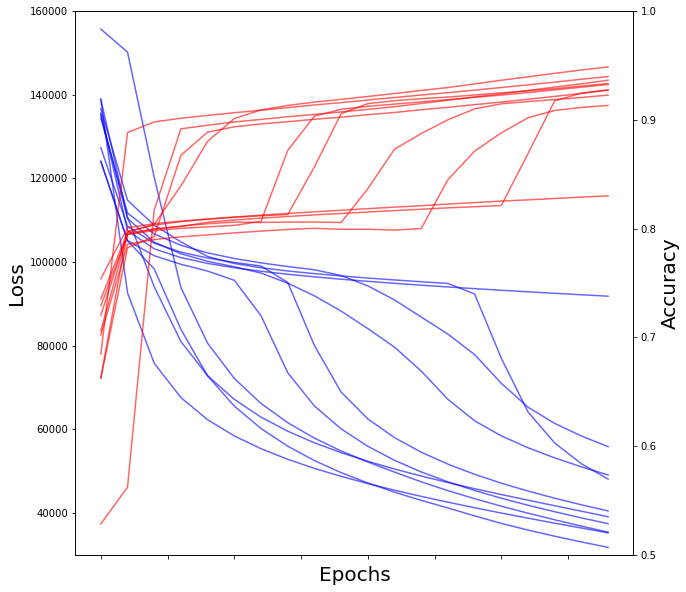

In [38]:
restarts=6
epochs=20

accidx=4
objidx=3
stepidx=1

for D in [D1]:
    fig,axes = plt.subplots(1,1,figsize=(10,10))
    rightax=axes.twinx()
    axes.set_ylim((30000,160000))    
    rightax.set_ylim((0.5,1.0))
    axes.set_xticklabels([])
    
    axes.set_xlabel('Epochs',fontsize=20)
    axes.set_ylabel('Loss',fontsize=20)
    rightax.set_ylabel('Accuracy',fontsize=20)
    
    for restarts in [10]:
        for r in range(restarts):
            axes.plot(range(epochs),-D[r*epochs:(r+1)*epochs,objidx],c='b',alpha=0.6)
            rightax.plot(range(epochs),D[r*epochs:(r+1)*epochs,accidx],c='r',alpha=0.6)
    plt.show()    

In [9]:
# Learning curves from MyGNN notebook:

gnncurves=pickle.load( open( 'GraphNN-develop/alpha1-[4]-pytorch-data.p', "rb" ) )

In [30]:
gnncurves['accuracy'].shape

(10, 20)

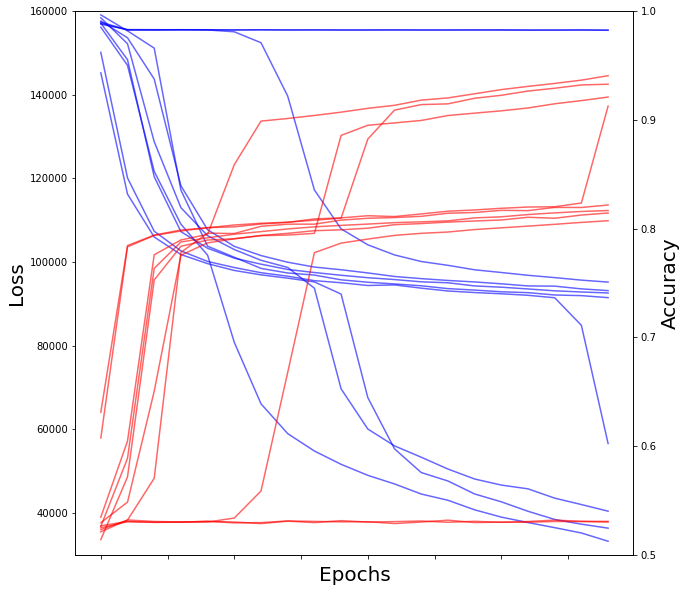

In [39]:
fig,axes = plt.subplots(1,1,figsize=(10,10))
rightax=axes.twinx()
axes.set_ylim((30000,160000))    
rightax.set_ylim((0.5,1.0))
axes.set_xticklabels([])

axes.set_xlabel('Epochs',fontsize=20)
axes.set_ylabel('Loss',fontsize=20)
rightax.set_ylabel('Accuracy',fontsize=20)

for i in range(10):
    axes.plot(range(epochs), gnncurves['loss'][i,:],c='b',alpha=0.6)
    rightax.plot(range(epochs),gnncurves['accuracy'][i,:],c='r',alpha=0.6)

plt.show()    

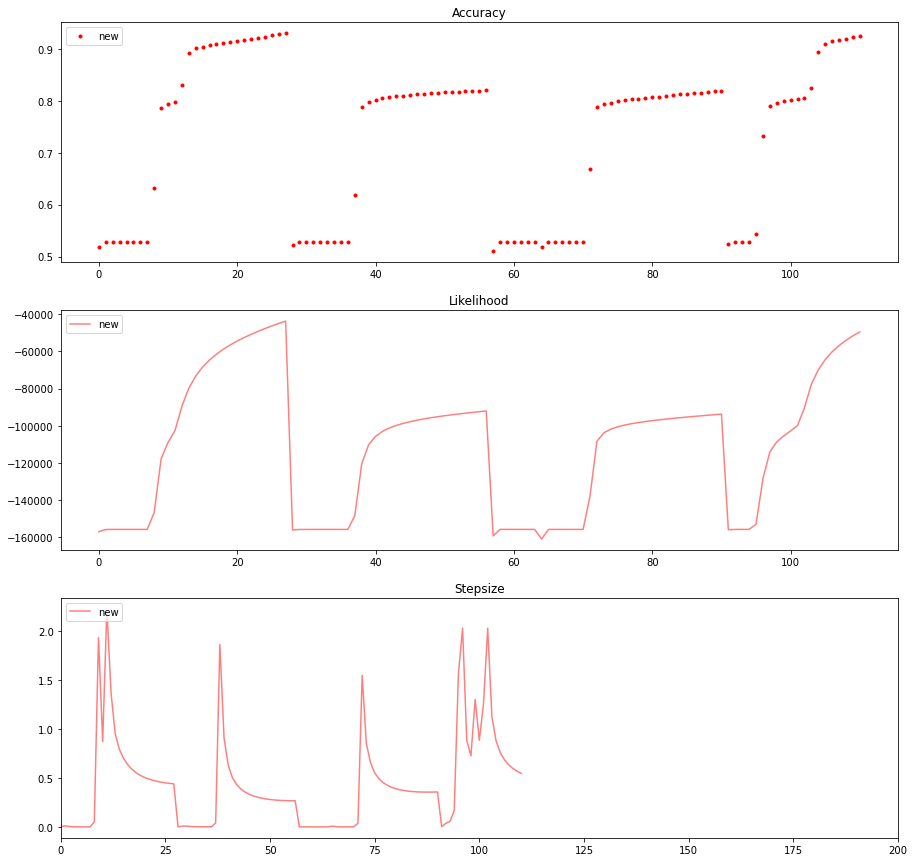

In [4]:
D=np.genfromtxt("stratolog.txt",delimiter='\t')
#D2=np.genfromtxt("Expressivity/runlog-[8]-p1.csv",delimiter='\t')
#D=np.genfromtxt("systemout.txt",comments='#',skip_header=5)
#D2=np.genfromtxt("GraphNN/systemout.txt",comments='#')
fig,axes = plt.subplots(3,1,figsize=(15,15))

accidx=4
objidx=3
stepidx=2


xrange=(0,200)

# ACCURACY
#axes[0].plot(D2[:,4],label="old",c='b',alpha=0.5)
axes[0].plot(D[:,accidx],'.',label="new",c='r',alpha=1.0)
#axes[0].plot(D2[:,3],label="old",c='b',alpha=0.5)
#axes[0].axhline(y=0.8,c='r')
axes[0].set_ylim((0.5,1.0))
axes[0].set_xlim(xrange)
axes[0].autoscale()
axes[0].legend(loc='upper left')
axes[0].set_title('Accuracy')

#LIKELIHOOD
#axes[1].plot(D2[:,3],label="old",c='b',alpha=0.5)
axes[1].plot(D[:,objidx],label="new",c='r',alpha=0.5)
#axes[1].plot(D2[:,2],label="old",c='b',alpha=0.5)

axes[1].set_ylim((-200000,0))
axes[1].set_xlim(xrange)
axes[1].autoscale()
axes[1].legend(loc='upper left')
axes[1].set_title('Likelihood')

#STEPSIZE
axes[2].plot(D[:,stepidx],label="new",c='r',alpha=0.5)
#axes[2].plot(D2[:,2],label="old",c='b',alpha=0.5)

#axes[2].set_ylim((0,1.0))
axes[2].set_xlim(xrange)
axes[2].legend(loc='upper left')
axes[2].set_title('Stepsize')

plt.show()

### with absolute time

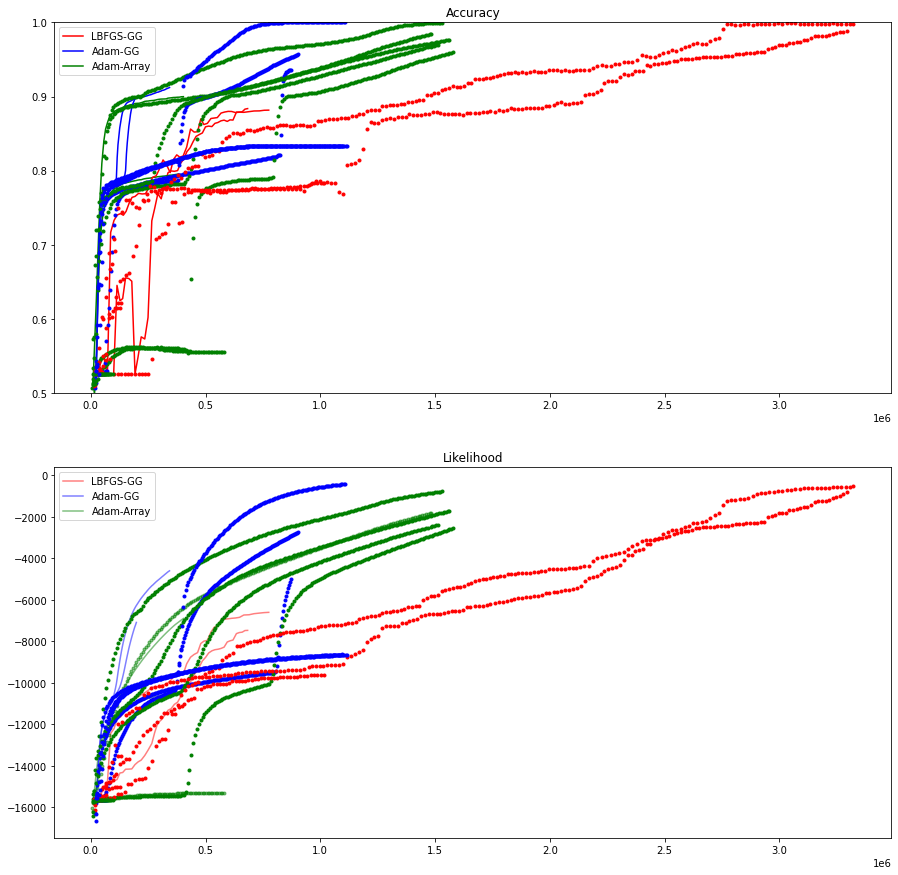

In [18]:
D=np.genfromtxt("GraphNN-develop/trace-gg.txt",comments='#',skip_header=5)
D1=np.genfromtxt("GraphNN-develop/trace-adam-gg.txt",comments='#',skip_header=5)
D2=np.genfromtxt("GraphNN-develop/trace-adam-array.txt",comments='#',skip_header=5)
D3=np.genfromtxt("GraphNN-develop/trace-adam-array-2.txt",comments='#',skip_header=5)
D4=np.genfromtxt("GraphNN-develop/trace-adam-gg-2.txt",comments='#',skip_header=5)
D5=np.genfromtxt("GraphNN-develop/trace-gg-2.txt",comments='#',skip_header=5)
D6=np.genfromtxt("GraphNN-develop/trace-adam-array-200.txt",comments='#',skip_header=5)
D7=np.genfromtxt("GraphNN-develop/trace-adam-gg-200.txt",comments='#',skip_header=5)
D8=np.genfromtxt("GraphNN-develop/trace-adam-array-200-2.txt",comments='#',skip_header=5)
D9=np.genfromtxt("GraphNN-develop/trace-gg-200-dtE-5.txt",comments='#',skip_header=5)
D10=np.genfromtxt("GraphNN-develop/trace-adam-array-b10-a05.txt",comments='#',skip_header=5)
D11=np.genfromtxt("GraphNN-develop/trace-adam-gg-b10-a05.txt",comments='#',skip_header=5)



fig,axes = plt.subplots(2,1,figsize=(15,15))

accidx=5
objidx=4
stepidx=2
timeidx=1


#xrange=(0,8000)

# ACCURACY

axes[0].plot(D[:,timeidx],D[:,accidx],label='LBFGS-GG',c='r',alpha=1.0)
axes[0].plot(D1[:,timeidx],D1[:,accidx-1],label='Adam-GG',c='b',alpha=1.0)
axes[0].plot(D2[:,timeidx],D2[:,accidx-1],label='Adam-Array',c='g',alpha=1.0)
axes[0].plot(D3[:,timeidx],D3[:,accidx-1],c='g',alpha=1.0)
axes[0].plot(D4[:,timeidx],D4[:,accidx-1],c='b',alpha=1.0)
axes[0].plot(D5[:,timeidx],D5[:,accidx],c='r',alpha=1.0)
axes[0].plot(D6[:,timeidx],D6[:,accidx-1],'.',c='g',alpha=1.0)
axes[0].plot(D7[:,timeidx],D7[:,accidx-1],'.',c='b',alpha=1.0)
axes[0].plot(D8[:,timeidx],D8[:,accidx-1],'.',c='g',alpha=1.0)
axes[0].plot(D9[:,timeidx],D9[:,accidx],'.',c='r',alpha=1.0)
axes[0].plot(D10[:,timeidx],D10[:,accidx-1],'.',c='g',alpha=1.0)
axes[0].plot(D11[:,timeidx],D11[:,accidx-1],'.',c='b',alpha=1.0)

#axes[0].axhline(y=0.8,c='r')
axes[0].set_ylim((0.5,1.0))
#axes[0].set_xlim(xrange)
axes[0].legend(loc='upper left')
axes[0].set_title('Accuracy')

#LIKELIHOOD
axes[1].plot(D[:,timeidx],D[:,objidx],label="LBFGS-GG",c='r',alpha=0.5)
axes[1].plot(D1[:,timeidx],D1[:,objidx-1],label="Adam-GG",c='b',alpha=0.5)
axes[1].plot(D2[:,timeidx],D2[:,objidx-1],label="Adam-Array",c='g',alpha=0.5)
axes[1].plot(D3[:,timeidx],D3[:,objidx-1],c='g',alpha=0.5)
axes[1].plot(D4[:,timeidx],D4[:,objidx-1],c='b',alpha=0.5)
axes[1].plot(D5[:,timeidx],D5[:,objidx],c='r',alpha=0.5)
axes[1].plot(D6[:,timeidx],D6[:,objidx-1],'.',c='g',alpha=0.5)
axes[1].plot(D7[:,timeidx],D7[:,objidx-1],'.',c='b',alpha=1.0)
axes[1].plot(D8[:,timeidx],D8[:,objidx-1],'.',c='g',alpha=1.0)
axes[1].plot(D9[:,timeidx],D9[:,objidx],'.',c='r',alpha=1.0)
axes[1].plot(D10[:,timeidx],D10[:,objidx-1],'.',c='g',alpha=1.0)
axes[1].plot(D11[:,timeidx],D11[:,objidx-1],'.',c='b',alpha=1.0)
#axes[1].set_ylim((-250000,0))
axes[1].legend(loc='upper left')
axes[1].set_title('Likelihood')

# #STEPSIZE
# axes[2].plot(D[:,stepidx],label="new",c='r',alpha=0.5)
# #axes[2].plot(D2[:,2],label="old",c='b',alpha=0.5)

# #axes[2].set_ylim((0,1.0))
# axes[2].set_xlim(xrange)
# axes[2].legend(loc='upper left')
# axes[2].set_title('Stepsize')

plt.show()

In [5]:
D[:,accidx]

array([-15671.47213354, -15557.64060321, -15513.14327166, -14885.53229029,
       -14837.07751406, -14720.7694676 , -14658.86677696, -14338.33786756,
       -14316.49012476, -14158.71516619, -14153.09705469, -14143.1502932 ,
       -13933.75682176, -13807.12393814, -13716.22035891, -13497.70067181,
       -13241.47104538, -12920.07319212, -12386.35368477, -11928.73633782,
       -11785.15787226, -11571.51827097, -11316.89075267, -11240.63644436,
       -11032.60938166, -10928.65030952, -10664.09347515, -10329.33804231,
       -10035.60737136,  -9992.06014359,  -9659.7899451 ])